In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *
import keras.backend as K

Using TensorFlow backend.
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
China_concat = pd.read_csv('../data/Concat/China_concat.csv', header=0)
Asia_concat = pd.read_csv('../data/Concat/Asia_concat.csv', header=0)
America_concat = pd.read_csv('../data/Concat/America_concat.csv', header=0)
Africa_concat = pd.read_csv('../data/Concat/Africa_concat.csv', header=0)
Europe_concat = pd.read_csv('../data/Concat/Europe_concat.csv', header=0)
Oceania_concat = pd.read_csv('../data/Concat/Oceania_concat.csv', header=0)

In [3]:
Test = pd.read_csv('../data/Test/Oceania_test_data.csv')
Test['Date'] = [20200429, 20200430, 20200501,20200502,20200503,20200504,20200505]
Test.set_index('Date',inplace=True)

In [4]:
df = pd.DataFrame()

Oceania_concat.set_index('Date',inplace=True)
label = Oceania_concat[Oceania_concat.columns[-1]]
#test_df = label[-7:]
Oceania_concat = Oceania_concat.loc[20200101:20200428]


df['Confirm'] = (Oceania_concat['Daily_confirmed'] + Oceania_concat['Daily_deaths']) / Oceania_concat['Total_confirmed']
df['Flight'] = Oceania_concat['Passenger_arrivals'] / Oceania_concat['Flight_arrivals']
df['Ship'] = ( Oceania_concat['Ship_crew(korea)'] + Oceania_concat['Ship_crew(foreign)'] + Oceania_concat['Ship_passenger'] ) / Oceania_concat['Ship_count']
df['News'] = Oceania_concat['News_Negative'] / Oceania_concat['News_Sum']
#df['Date'] = Asia_concat['Date'].astype(int)
    
df.fillna(0, inplace = True)
#df.set_index('Date',inplace=True)



In [5]:
sc = MinMaxScaler()

df['Confirm'] = sc.fit_transform(pd.DataFrame(df['Confirm']))
df['Flight'] = sc.fit_transform(pd.DataFrame(df['Flight']))
df['Ship'] = sc.fit_transform(pd.DataFrame(df['Ship']))
df['News'] = sc.fit_transform(pd.DataFrame(df['News']))

In [6]:
df = pd.concat([df,Test])

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [8]:
df_s = series_to_supervised(df, 14, 0)

In [9]:
#df_s = df

In [10]:
X_train = np.array(df_s.loc[:20200428])
X_test = np.array(df_s.loc[20200429:])

y_train = np.array(label.loc[20200115:20200428])
y_test = np.array(label.loc[20200429:20200505])

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((105, 60, 1), (7, 60, 1), (105,), (7,))

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.models import load_model


K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
xLstm_1 = LSTM(20, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xInput)
#xLstm_2 = LSTM(20, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xLstm_1)
#xLstm_3 = LSTM(50, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xLstm_2)
xLstm_4 = Bidirectional(LSTM(20))(xLstm_1)
xOutput = Dense(1)(xLstm_4)


model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam', metrics = [ 'mae' ])


 # 학습
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=2)

model.fit(X_train, y_train, epochs=2000, batch_size=1, verbose=2, shuffle=False)



 # 예측
y_hat = model.predict(X_test, batch_size=1)


Epoch 1/2000
 - 3s - loss: 0.0099 - mae: 0.0213
Epoch 2/2000
 - 2s - loss: 0.0099 - mae: 0.0239
Epoch 3/2000
 - 2s - loss: 0.0098 - mae: 0.0226
Epoch 4/2000
 - 2s - loss: 0.0098 - mae: 0.0222
Epoch 5/2000
 - 2s - loss: 0.0097 - mae: 0.0219
Epoch 6/2000
 - 2s - loss: 0.0097 - mae: 0.0224
Epoch 7/2000
 - 2s - loss: 0.0096 - mae: 0.0221
Epoch 8/2000
 - 2s - loss: 0.0096 - mae: 0.0224
Epoch 9/2000
 - 2s - loss: 0.0096 - mae: 0.0225
Epoch 10/2000
 - 2s - loss: 0.0095 - mae: 0.0228
Epoch 11/2000
 - 2s - loss: 0.0095 - mae: 0.0229
Epoch 12/2000
 - 2s - loss: 0.0095 - mae: 0.0231
Epoch 13/2000
 - 2s - loss: 0.0095 - mae: 0.0232
Epoch 14/2000
 - 2s - loss: 0.0095 - mae: 0.0233
Epoch 15/2000
 - 2s - loss: 0.0095 - mae: 0.0235
Epoch 16/2000
 - 2s - loss: 0.0095 - mae: 0.0236
Epoch 17/2000
 - 2s - loss: 0.0095 - mae: 0.0237
Epoch 18/2000
 - 2s - loss: 0.0094 - mae: 0.0239
Epoch 19/2000
 - 2s - loss: 0.0094 - mae: 0.0240
Epoch 20/2000
 - 2s - loss: 0.0094 - mae: 0.0242
Epoch 21/2000
 - 2s - loss: 

Epoch 163/2000
 - 2s - loss: 8.5793e-04 - mae: 0.0143
Epoch 164/2000
 - 2s - loss: 9.0896e-04 - mae: 0.0178
Epoch 165/2000
 - 2s - loss: 6.6387e-04 - mae: 0.0138
Epoch 166/2000
 - 2s - loss: 2.9208e-04 - mae: 0.0126
Epoch 167/2000
 - 2s - loss: 7.7319e-04 - mae: 0.0153
Epoch 168/2000
 - 2s - loss: 5.6722e-04 - mae: 0.0122
Epoch 169/2000
 - 2s - loss: 1.8611e-04 - mae: 0.0103
Epoch 170/2000
 - 2s - loss: 3.8180e-04 - mae: 0.0103
Epoch 171/2000
 - 2s - loss: 7.3472e-04 - mae: 0.0153
Epoch 172/2000
 - 2s - loss: 0.0106 - mae: 0.0274
Epoch 173/2000
 - 2s - loss: 0.0062 - mae: 0.0204
Epoch 174/2000
 - 2s - loss: 6.2898e-04 - mae: 0.0163
Epoch 175/2000
 - 2s - loss: 2.8491e-04 - mae: 0.0121
Epoch 176/2000
 - 2s - loss: 3.4269e-04 - mae: 0.0117
Epoch 177/2000
 - 2s - loss: 8.6597e-04 - mae: 0.0159
Epoch 178/2000
 - 2s - loss: 0.0035 - mae: 0.0161
Epoch 179/2000
 - 2s - loss: 0.0071 - mae: 0.0297
Epoch 180/2000
 - 2s - loss: 0.0032 - mae: 0.0209
Epoch 181/2000
 - 2s - loss: 0.0015 - mae: 0.021

Epoch 316/2000
 - 2s - loss: 7.5394e-06 - mae: 0.0019
Epoch 317/2000
 - 2s - loss: 7.2910e-06 - mae: 0.0019
Epoch 318/2000
 - 2s - loss: 7.0737e-06 - mae: 0.0019
Epoch 319/2000
 - 2s - loss: 6.9162e-06 - mae: 0.0019
Epoch 320/2000
 - 2s - loss: 7.8152e-06 - mae: 0.0020
Epoch 321/2000
 - 2s - loss: 1.8828e-05 - mae: 0.0023
Epoch 322/2000
 - 2s - loss: 1.8983e-04 - mae: 0.0040
Epoch 323/2000
 - 2s - loss: 0.0027 - mae: 0.0146
Epoch 324/2000
 - 2s - loss: 5.3050e-04 - mae: 0.0088
Epoch 325/2000
 - 2s - loss: 0.0032 - mae: 0.0157
Epoch 326/2000
 - 2s - loss: 0.0080 - mae: 0.0289
Epoch 327/2000
 - 2s - loss: 0.0016 - mae: 0.0130
Epoch 328/2000
 - 2s - loss: 0.0028 - mae: 0.0125
Epoch 329/2000
 - 2s - loss: 0.0040 - mae: 0.0122
Epoch 330/2000
 - 2s - loss: 0.0012 - mae: 0.0132
Epoch 331/2000
 - 2s - loss: 8.6600e-05 - mae: 0.0049
Epoch 332/2000
 - 2s - loss: 2.5609e-05 - mae: 0.0035
Epoch 333/2000
 - 2s - loss: 2.0420e-05 - mae: 0.0031
Epoch 334/2000
 - 2s - loss: 1.8733e-05 - mae: 0.0030
Ep

Epoch 469/2000
 - 2s - loss: 4.6225e-06 - mae: 0.0015
Epoch 470/2000
 - 2s - loss: 4.3827e-06 - mae: 0.0014
Epoch 471/2000
 - 2s - loss: 4.1741e-06 - mae: 0.0014
Epoch 472/2000
 - 2s - loss: 3.9879e-06 - mae: 0.0014
Epoch 473/2000
 - 2s - loss: 3.8192e-06 - mae: 0.0013
Epoch 474/2000
 - 2s - loss: 3.6644e-06 - mae: 0.0013
Epoch 475/2000
 - 2s - loss: 3.5215e-06 - mae: 0.0013
Epoch 476/2000
 - 2s - loss: 3.3887e-06 - mae: 0.0012
Epoch 477/2000
 - 2s - loss: 3.2647e-06 - mae: 0.0012
Epoch 478/2000
 - 2s - loss: 3.1487e-06 - mae: 0.0012
Epoch 479/2000
 - 2s - loss: 3.0400e-06 - mae: 0.0012
Epoch 480/2000
 - 2s - loss: 2.9379e-06 - mae: 0.0011
Epoch 481/2000
 - 2s - loss: 2.8419e-06 - mae: 0.0011
Epoch 482/2000
 - 2s - loss: 2.7517e-06 - mae: 0.0011
Epoch 483/2000
 - 2s - loss: 2.6669e-06 - mae: 0.0011
Epoch 484/2000
 - 2s - loss: 2.5872e-06 - mae: 0.0011
Epoch 485/2000
 - 2s - loss: 2.5129e-06 - mae: 0.0011
Epoch 486/2000
 - 2s - loss: 2.4442e-06 - mae: 0.0010
Epoch 487/2000
 - 2s - loss:

Epoch 620/2000
 - 2s - loss: 6.8664e-05 - mae: 0.0032
Epoch 621/2000
 - 2s - loss: 5.7739e-05 - mae: 0.0034
Epoch 622/2000
 - 2s - loss: 0.0027 - mae: 0.0084
Epoch 623/2000
 - 2s - loss: 9.0078e-04 - mae: 0.0148
Epoch 624/2000
 - 2s - loss: 6.3829e-05 - mae: 0.0051
Epoch 625/2000
 - 2s - loss: 2.7131e-05 - mae: 0.0025
Epoch 626/2000
 - 2s - loss: 7.9439e-06 - mae: 0.0022
Epoch 627/2000
 - 2s - loss: 5.5142e-06 - mae: 0.0019
Epoch 628/2000
 - 2s - loss: 5.1834e-06 - mae: 0.0018
Epoch 629/2000
 - 2s - loss: 5.0459e-06 - mae: 0.0018
Epoch 630/2000
 - 2s - loss: 5.5461e-06 - mae: 0.0017
Epoch 631/2000
 - 2s - loss: 5.1941e-06 - mae: 0.0017
Epoch 632/2000
 - 2s - loss: 5.8766e-06 - mae: 0.0017
Epoch 633/2000
 - 2s - loss: 4.9184e-06 - mae: 0.0017
Epoch 634/2000
 - 2s - loss: 5.0615e-06 - mae: 0.0016
Epoch 635/2000
 - 2s - loss: 4.6485e-06 - mae: 0.0016
Epoch 636/2000
 - 2s - loss: 4.5680e-06 - mae: 0.0015
Epoch 637/2000
 - 2s - loss: 4.5590e-06 - mae: 0.0016
Epoch 638/2000
 - 2s - loss: 4.5

Epoch 771/2000
 - 2s - loss: 2.2498e-06 - mae: 0.0012
Epoch 772/2000
 - 2s - loss: 2.0692e-06 - mae: 0.0011
Epoch 773/2000
 - 2s - loss: 1.9152e-06 - mae: 0.0011
Epoch 774/2000
 - 2s - loss: 1.7849e-06 - mae: 0.0010
Epoch 775/2000
 - 2s - loss: 1.6722e-06 - mae: 0.0010
Epoch 776/2000
 - 2s - loss: 1.5788e-06 - mae: 9.9405e-04
Epoch 777/2000
 - 2s - loss: 1.4927e-06 - mae: 9.7378e-04
Epoch 778/2000
 - 2s - loss: 1.4355e-06 - mae: 9.6076e-04
Epoch 779/2000
 - 2s - loss: 1.3494e-06 - mae: 9.4627e-04
Epoch 780/2000
 - 2s - loss: 1.5077e-06 - mae: 9.7677e-04
Epoch 781/2000
 - 2s - loss: 1.9482e-06 - mae: 9.4909e-04
Epoch 782/2000
 - 2s - loss: 9.6061e-06 - mae: 0.0017
Epoch 783/2000
 - 2s - loss: 4.2382e-05 - mae: 0.0024
Epoch 784/2000
 - 2s - loss: 8.0892e-05 - mae: 0.0038
Epoch 785/2000
 - 2s - loss: 6.0717e-05 - mae: 0.0028
Epoch 786/2000
 - 2s - loss: 0.0025 - mae: 0.0089
Epoch 787/2000
 - 2s - loss: 0.0096 - mae: 0.0163
Epoch 788/2000
 - 2s - loss: 6.2890e-05 - mae: 0.0053
Epoch 789/20

Epoch 922/2000
 - 2s - loss: 6.2364e-06 - mae: 0.0014
Epoch 923/2000
 - 2s - loss: 5.4300e-06 - mae: 0.0013
Epoch 924/2000
 - 2s - loss: 5.7170e-06 - mae: 0.0013
Epoch 925/2000
 - 2s - loss: 6.1880e-06 - mae: 0.0014
Epoch 926/2000
 - 2s - loss: 7.6398e-06 - mae: 0.0015
Epoch 927/2000
 - 2s - loss: 9.6446e-06 - mae: 0.0018
Epoch 928/2000
 - 2s - loss: 1.2851e-05 - mae: 0.0020
Epoch 929/2000
 - 2s - loss: 1.6745e-05 - mae: 0.0024
Epoch 930/2000
 - 2s - loss: 2.0696e-05 - mae: 0.0025
Epoch 931/2000
 - 2s - loss: 2.3486e-05 - mae: 0.0028
Epoch 932/2000
 - 2s - loss: 2.3134e-05 - mae: 0.0025
Epoch 933/2000
 - 2s - loss: 2.0872e-05 - mae: 0.0025
Epoch 934/2000
 - 2s - loss: 1.8780e-05 - mae: 0.0022
Epoch 935/2000
 - 2s - loss: 1.4536e-05 - mae: 0.0020
Epoch 936/2000
 - 2s - loss: 2.0591e-05 - mae: 0.0020
Epoch 937/2000
 - 2s - loss: 2.1134e-05 - mae: 0.0021
Epoch 938/2000
 - 2s - loss: 2.1777e-05 - mae: 0.0023
Epoch 939/2000
 - 2s - loss: 2.1290e-05 - mae: 0.0022
Epoch 940/2000
 - 2s - loss:

Epoch 1071/2000
 - 2s - loss: 6.0877e-06 - mae: 0.0013
Epoch 1072/2000
 - 2s - loss: 6.4516e-06 - mae: 0.0013
Epoch 1073/2000
 - 2s - loss: 6.6699e-06 - mae: 0.0013
Epoch 1074/2000
 - 2s - loss: 7.7104e-06 - mae: 0.0014
Epoch 1075/2000
 - 2s - loss: 8.9983e-06 - mae: 0.0015
Epoch 1076/2000
 - 2s - loss: 1.0887e-05 - mae: 0.0017
Epoch 1077/2000
 - 2s - loss: 1.1862e-05 - mae: 0.0017
Epoch 1078/2000
 - 2s - loss: 1.3351e-05 - mae: 0.0019
Epoch 1079/2000
 - 2s - loss: 1.1992e-05 - mae: 0.0017
Epoch 1080/2000
 - 2s - loss: 1.2108e-05 - mae: 0.0018
Epoch 1081/2000
 - 2s - loss: 1.0117e-05 - mae: 0.0016
Epoch 1082/2000
 - 2s - loss: 5.9467e-05 - mae: 0.0025
Epoch 1083/2000
 - 2s - loss: 5.4507e-05 - mae: 0.0040
Epoch 1084/2000
 - 2s - loss: 0.0082 - mae: 0.0115
Epoch 1085/2000
 - 2s - loss: 0.0031 - mae: 0.0130
Epoch 1086/2000
 - 2s - loss: 0.0012 - mae: 0.0066
Epoch 1087/2000
 - 2s - loss: 1.1951e-05 - mae: 0.0024
Epoch 1088/2000
 - 2s - loss: 6.5048e-06 - mae: 0.0018
Epoch 1089/2000
 - 2s 

 - 2s - loss: 1.0815e-06 - mae: 8.4087e-04
Epoch 1218/2000
 - 2s - loss: 1.0316e-06 - mae: 8.3236e-04
Epoch 1219/2000
 - 2s - loss: 1.2453e-06 - mae: 8.2455e-04
Epoch 1220/2000
 - 2s - loss: 1.8295e-06 - mae: 0.0010
Epoch 1221/2000
 - 2s - loss: 3.9145e-06 - mae: 0.0011
Epoch 1222/2000
 - 2s - loss: 1.0386e-05 - mae: 0.0019
Epoch 1223/2000
 - 2s - loss: 2.5285e-05 - mae: 0.0024
Epoch 1224/2000
 - 2s - loss: 3.5346e-05 - mae: 0.0031
Epoch 1225/2000
 - 2s - loss: 3.3796e-05 - mae: 0.0027
Epoch 1226/2000
 - 2s - loss: 1.4479e-05 - mae: 0.0021
Epoch 1227/2000
 - 2s - loss: 6.9347e-06 - mae: 0.0014
Epoch 1228/2000
 - 2s - loss: 3.2208e-06 - mae: 0.0011
Epoch 1229/2000
 - 2s - loss: 1.9854e-06 - mae: 8.1762e-04
Epoch 1230/2000
 - 2s - loss: 1.3282e-06 - mae: 7.5801e-04
Epoch 1231/2000
 - 2s - loss: 1.1501e-06 - mae: 6.4117e-04
Epoch 1232/2000
 - 2s - loss: 1.0024e-06 - mae: 6.8450e-04
Epoch 1233/2000
 - 2s - loss: 1.1056e-06 - mae: 6.0591e-04
Epoch 1234/2000
 - 2s - loss: 1.2198e-06 - mae: 7

Epoch 1361/2000
 - 2s - loss: 2.0450e-06 - mae: 7.2404e-04
Epoch 1362/2000
 - 2s - loss: 2.2876e-06 - mae: 7.9401e-04
Epoch 1363/2000
 - 2s - loss: 3.4710e-06 - mae: 9.1010e-04
Epoch 1364/2000
 - 2s - loss: 4.8128e-06 - mae: 0.0011
Epoch 1365/2000
 - 2s - loss: 7.7851e-06 - mae: 0.0013
Epoch 1366/2000
 - 2s - loss: 1.0611e-05 - mae: 0.0016
Epoch 1367/2000
 - 2s - loss: 1.3743e-05 - mae: 0.0018
Epoch 1368/2000
 - 2s - loss: 1.3209e-05 - mae: 0.0018
Epoch 1369/2000
 - 2s - loss: 1.1604e-05 - mae: 0.0016
Epoch 1370/2000
 - 2s - loss: 8.3435e-06 - mae: 0.0014
Epoch 1371/2000
 - 2s - loss: 6.4060e-06 - mae: 0.0012
Epoch 1372/2000
 - 2s - loss: 4.6081e-06 - mae: 0.0011
Epoch 1373/2000
 - 2s - loss: 3.9738e-06 - mae: 9.7422e-04
Epoch 1374/2000
 - 2s - loss: 3.3201e-06 - mae: 9.2442e-04
Epoch 1375/2000
 - 2s - loss: 3.4785e-06 - mae: 9.1424e-04
Epoch 1376/2000
 - 2s - loss: 3.4732e-06 - mae: 9.5322e-04
Epoch 1377/2000
 - 2s - loss: 4.3116e-06 - mae: 0.0010
Epoch 1378/2000
 - 2s - loss: 5.0018e

Epoch 1505/2000
 - 2s - loss: 2.7305e-06 - mae: 8.8572e-04
Epoch 1506/2000
 - 2s - loss: 1.8831e-06 - mae: 7.4208e-04
Epoch 1507/2000
 - 2s - loss: 1.7526e-06 - mae: 7.0413e-04
Epoch 1508/2000
 - 2s - loss: 1.5437e-06 - mae: 6.6535e-04
Epoch 1509/2000
 - 2s - loss: 1.9080e-06 - mae: 7.2398e-04
Epoch 1510/2000
 - 2s - loss: 2.1787e-06 - mae: 7.5080e-04
Epoch 1511/2000
 - 2s - loss: 3.3125e-06 - mae: 9.2768e-04
Epoch 1512/2000
 - 2s - loss: 4.5959e-06 - mae: 0.0010
Epoch 1513/2000
 - 2s - loss: 7.2571e-06 - mae: 0.0013
Epoch 1514/2000
 - 2s - loss: 9.3886e-06 - mae: 0.0014
Epoch 1515/2000
 - 2s - loss: 1.1483e-05 - mae: 0.0016
Epoch 1516/2000
 - 2s - loss: 1.0770e-05 - mae: 0.0015
Epoch 1517/2000
 - 2s - loss: 9.3584e-06 - mae: 0.0015
Epoch 1518/2000
 - 2s - loss: 6.9520e-06 - mae: 0.0013
Epoch 1519/2000
 - 2s - loss: 5.6640e-06 - mae: 0.0011
Epoch 1520/2000
 - 2s - loss: 4.4411e-06 - mae: 0.0010
Epoch 1521/2000
 - 2s - loss: 4.3232e-06 - mae: 9.5602e-04
Epoch 1522/2000
 - 2s - loss: 3.7

Epoch 1651/2000
 - 2s - loss: 2.1588e-07 - mae: 3.1756e-04
Epoch 1652/2000
 - 2s - loss: 2.0295e-07 - mae: 3.1043e-04
Epoch 1653/2000
 - 2s - loss: 1.9843e-07 - mae: 3.0324e-04
Epoch 1654/2000
 - 2s - loss: 1.8816e-07 - mae: 2.9961e-04
Epoch 1655/2000
 - 2s - loss: 1.8810e-07 - mae: 2.9821e-04
Epoch 1656/2000
 - 2s - loss: 1.7676e-07 - mae: 2.9644e-04
Epoch 1657/2000
 - 2s - loss: 1.8793e-07 - mae: 2.9990e-04
Epoch 1658/2000
 - 2s - loss: 1.7548e-07 - mae: 2.9502e-04
Epoch 1659/2000
 - 2s - loss: 2.5370e-07 - mae: 3.3860e-04
Epoch 1660/2000
 - 2s - loss: 3.6286e-07 - mae: 3.8117e-04
Epoch 1661/2000
 - 2s - loss: 1.3195e-06 - mae: 5.8746e-04
Epoch 1662/2000
 - 2s - loss: 4.6694e-06 - mae: 9.6970e-04
Epoch 1663/2000
 - 2s - loss: 1.7094e-05 - mae: 0.0017
Epoch 1664/2000
 - 2s - loss: 2.8826e-05 - mae: 0.0022
Epoch 1665/2000
 - 2s - loss: 1.9928e-05 - mae: 0.0019
Epoch 1666/2000
 - 2s - loss: 8.7183e-06 - mae: 0.0014
Epoch 1667/2000
 - 2s - loss: 3.3543e-06 - mae: 8.7001e-04
Epoch 1668/20

Epoch 1793/2000
 - 2s - loss: 8.1064e-07 - mae: 5.4631e-04
Epoch 1794/2000
 - 2s - loss: 5.1359e-07 - mae: 4.9169e-04
Epoch 1795/2000
 - 2s - loss: 5.9331e-07 - mae: 4.9713e-04
Epoch 1796/2000
 - 2s - loss: 4.4519e-07 - mae: 4.5697e-04
Epoch 1797/2000
 - 2s - loss: 6.6146e-07 - mae: 5.1521e-04
Epoch 1798/2000
 - 2s - loss: 6.2747e-07 - mae: 5.0731e-04
Epoch 1799/2000
 - 2s - loss: 1.2193e-06 - mae: 6.2583e-04
Epoch 1800/2000
 - 2s - loss: 1.7281e-06 - mae: 7.1316e-04
Epoch 1801/2000
 - 2s - loss: 4.0621e-06 - mae: 9.7718e-04
Epoch 1802/2000
 - 2s - loss: 7.1901e-06 - mae: 0.0012
Epoch 1803/2000
 - 2s - loss: 1.3129e-05 - mae: 0.0016
Epoch 1804/2000
 - 2s - loss: 1.4264e-05 - mae: 0.0017
Epoch 1805/2000
 - 2s - loss: 1.2175e-05 - mae: 0.0016
Epoch 1806/2000
 - 2s - loss: 7.2236e-06 - mae: 0.0013
Epoch 1807/2000
 - 2s - loss: 4.6557e-06 - mae: 0.0010
Epoch 1808/2000
 - 2s - loss: 2.7865e-06 - mae: 8.8722e-04
Epoch 1809/2000
 - 2s - loss: 2.2463e-06 - mae: 7.6944e-04
Epoch 1810/2000
 - 2s

 - 2s - loss: 2.2906e-06 - mae: 0.0011
Epoch 1939/2000
 - 2s - loss: 5.3279e-06 - mae: 0.0012
Epoch 1940/2000
 - 2s - loss: 3.8666e-05 - mae: 0.0021
Epoch 1941/2000
 - 2s - loss: 3.3248e-05 - mae: 0.0026
Epoch 1942/2000
 - 2s - loss: 1.9974e-05 - mae: 0.0021
Epoch 1943/2000
 - 2s - loss: 6.7751e-06 - mae: 0.0017
Epoch 1944/2000
 - 2s - loss: 2.4534e-06 - mae: 0.0011
Epoch 1945/2000
 - 2s - loss: 2.1937e-06 - mae: 0.0011
Epoch 1946/2000
 - 2s - loss: 1.7530e-06 - mae: 9.7674e-04
Epoch 1947/2000
 - 2s - loss: 1.7343e-06 - mae: 9.6861e-04
Epoch 1948/2000
 - 2s - loss: 1.5719e-06 - mae: 9.2854e-04
Epoch 1949/2000
 - 2s - loss: 1.5372e-06 - mae: 9.1849e-04
Epoch 1950/2000
 - 2s - loss: 1.4372e-06 - mae: 8.9727e-04
Epoch 1951/2000
 - 2s - loss: 1.4045e-06 - mae: 8.9171e-04
Epoch 1952/2000
 - 2s - loss: 1.3346e-06 - mae: 8.7858e-04
Epoch 1953/2000
 - 2s - loss: 1.3147e-06 - mae: 8.7959e-04
Epoch 1954/2000
 - 2s - loss: 1.2723e-06 - mae: 8.6978e-04
Epoch 1955/2000
 - 2s - loss: 1.2885e-06 - ma

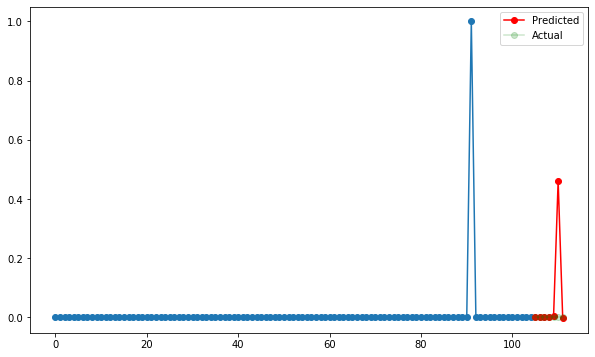

In [13]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(105,), 'o-')
plt.plot(b_axis, y_hat.reshape(7,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(7,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

In [14]:
y_test, y_hat

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([[ 0.0025504 ],
        [ 0.00218499],
        [ 0.00279255],
        [ 0.0027941 ],
        [ 0.00354878],
        [ 0.46126622],
        [-0.00186116]], dtype=float32))

In [15]:
y_hat

array([[ 0.0025504 ],
       [ 0.00218499],
       [ 0.00279255],
       [ 0.0027941 ],
       [ 0.00354878],
       [ 0.46126622],
       [-0.00186116]], dtype=float32)

In [16]:
y_test.sum(), y_hat.sum()

(0.0, 0.4732759)

In [17]:
model.save('../model/Oceania_model.h5')